In [19]:
import re

# Clean text
def clean_text(text):
    # Remove patterns at beginning of text such as "WASHINGTON (Reuters) -"
    cleaned_text = re.sub(r"^\S+(?:\s+\S+)*\s*\([^)]+\)\s*-", '', text)
    return cleaned_text

In [20]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

# Combining true and false datasets
true_df = pd.read_csv('True.csv')
false_df = pd.read_csv('Fake.csv')
 
true_df["fake_news_flag"] = 0

true_df['text'] = true_df['text'].apply(clean_text)
false_df["fake_news_flag"] = 1

combined_df = pd.concat([true_df, false_df], ignore_index=True)

combined_df["text"]


0         The head of a conservative Republican faction...
1         Transgender people will be allowed for the fi...
2         The special counsel investigation of links be...
3         Trump campaign adviser George Papadopoulos to...
4         President Donald Trump called on the U.S. Pos...
                               ...                        
44893    21st Century Wire says As 21WIRE reported earl...
44894    21st Century Wire says It s a familiar theme. ...
44895    Patrick Henningsen  21st Century WireRemember ...
44896    21st Century Wire says Al Jazeera America will...
44897    21st Century Wire says As 21WIRE predicted in ...
Name: text, Length: 44898, dtype: object

In [21]:
# Manually clean
example_text = combined_df['text'].iloc[12300]
example_text = "IADSF DF (Reuters) - Nato"
cleaned_example = re.sub(r"^\S+(?:\s+\S+)*\s*\([^)]+\)\s*-", '', example_text)
print(f"Original: {example_text}")
print(f"Cleaned: {cleaned_example}")


Original: IADSF DF (Reuters) - Nato
Cleaned:  Nato


In [22]:
# Processing WELFake_Dataset.csv
big_df = pd.read_csv("WELFake_Dataset.csv")
big_df["fake_news_flag"] = big_df["label"]
big_df["fake_news_flag"] = big_df["fake_news_flag"].replace({0: 1, 1: 0})
big_df.drop(columns=["Unnamed: 0","label"], inplace= True)
big_df = big_df.dropna()
big_df.head()

,title,text,fake_news_flag
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,0
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",0
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,1
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",0
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,0


In [23]:

# Dropping columns and adding the processed WELFake_Dataset data
combined_df.drop(columns=['date','subject'], inplace= True)

combined_df = pd.concat([combined_df, big_df], ignore_index=True)

combined_df = shuffle(combined_df, random_state=42)
combined_df.head()
combined_df.tail()



,title,text,fake_news_flag
76820,THIS ONE STATEMENT IS THE KEY TO THE 2016 ELEC...,Listen up people! This is great! Lou Dobbs get...,0
110268,Virginia court rules for Trump in travel ban d...,(Reuters) - A U.S. federal judge in Virginia r...,1
103694,Compromises being reached in Iran talks,Washington (CNN) Compromises on some of the cr...,1
860,Republican tax plan would deal financial hit t...,The Republican tax plan unveiled on Thursday ...,0
15795,U.N. refugee commissioner says Australia must ...,The U.N. High Commissioner for Refugees said ...,0


In [24]:
# Saving new full dataset to CSV to easily use later
combined_df.to_csv('fulldata.csv', index=False)

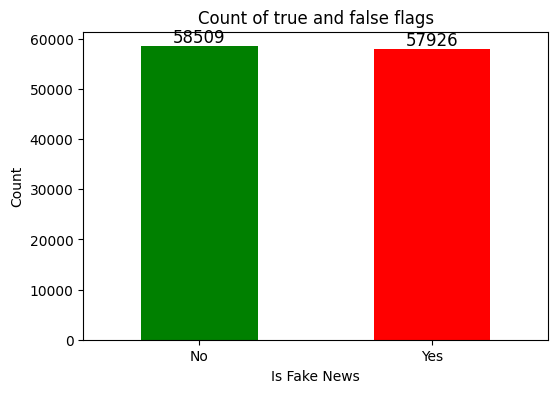

In [25]:
import matplotlib.pyplot as plt


counts = combined_df['fake_news_flag'].value_counts()

plt.figure(figsize=(6, 4))
ax = counts.plot(kind='bar', color=['green', 'red'])

plt.xlabel('Is Fake News')
plt.ylabel('Count')
plt.title('Count of true and false flags')

for idx, value in enumerate(counts):
    ax.text(idx, value + 0.1, str(value), ha='center', va='bottom', fontsize=12)


plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.show()

Create clustering based on topics using embeddings

In [30]:
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
# Preprocessing and vectorizing the text data
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(combined_df['text'])

# Fit NMF model for topic modeling
num_topics = 9  # Adjust based on your model
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(X)

# Top words per topic
terms = vectorizer.get_feature_names_out()
topic_labels = []

for topic_idx, topic in enumerate(nmf_model.components_):
    topic_words = [terms[i] for i in topic.argsort()[:-10 - 1:-1]]  # Top 10 words
    print(f"Topic #{topic_idx}: {' '.join(topic_words)}")

# Assigning topic labels based on inspection
topic_label_map = {
    0: 'U.S. Politics',
    1: 'International Affairs',
    2: 'U.S. Politics',
    3: 'International Affairs',
    4: 'U.S. Politics',
    5: 'General News and Announcements',
    6: 'International Affairs',
    7: 'Legal and Political',
    8: 'Social Issue'
}

# Assign the dominant topic to each article
topic_assignments = nmf_model.transform(X)
dominant_topic = topic_assignments.argmax(axis=1)

# Map the dominant topic to the label
combined_df['dominant_topic'] = dominant_topic
combined_df['topic_label'] = combined_df['dominant_topic'].map(topic_label_map)

# Show results
print(combined_df[['title', 'topic_label']])

combined_df

Topic #0: trump donald president campaign said white republican twitter presidential image
Topic #1: said government state minister reuters military islamic police united security
Topic #2: clinton hillary campaign fbi emails sanders email election democratic foundation
Topic #3: russia russian putin moscow intelligence syria fbi comey investigation committee
Topic #4: tax republican senate republicans house party percent said vote democrats
Topic #5: mr said ms mrs new york company years times like
Topic #6: korea north china nuclear korean south missile united chinese sanctions
Topic #7: obama court president administration supreme justice white house federal judge
Topic #8: people like just black police don video twitter com women
                                                    title  \
103573  N.J. Democrats divided on renewing 'Bridgegate...   
49580   NO KIDDING! HERE’S WHY HILLARY SUPPORTERS Will...   
78956           Iraqi Army: US Hindering Advance on Mosul   
51231   Brit

,title,text,fake_news_flag,dominant_topic,topic_label
103573,N.J. Democrats divided on renewing 'Bridgegate...,(This March 30 story was corrected to note Pr...,1,1,International Affairs
49580,NO KIDDING! HERE’S WHY HILLARY SUPPORTERS Will...,Wow! The Dems are so out of touch,0,0,U.S. Politics
78956,Iraqi Army: US Hindering Advance on Mosul,LUCIFER in the Temple of the Dog II ‹ › GPD is...,0,1,International Affairs
51231,Britain frustrated by slow pace of Brexit talk...,"MANCHESTER, England (Reuters) - Prime Minister...",1,1,International Affairs
101480,Israeli Trump supporters open campaign office ...,JERUSALEM (Reuters) - Israeli supporters of U....,1,1,International Affairs
...,...,...,...,...,...
76820,THIS ONE STATEMENT IS THE KEY TO THE 2016 ELEC...,Listen up people! This is great! Lou Dobbs get...,0,8,Social Issue
110268,Virginia court rules for Trump in travel ban d...,(Reuters) - A U.S. federal judge in Virginia r...,1,7,Legal and Political
103694,Compromises being reached in Iran talks,Washington (CNN) Compromises on some of the cr...,1,1,International Affairs
860,Republican tax plan would deal financial hit t...,The Republican tax plan unveiled on Thursday ...,0,4,U.S. Politics


In [31]:

combined_df.to_csv('labeled_fulldata.csv', index=False)
combined_df

,title,text,fake_news_flag,dominant_topic,topic_label
103573,N.J. Democrats divided on renewing 'Bridgegate...,(This March 30 story was corrected to note Pr...,1,1,International Affairs
49580,NO KIDDING! HERE’S WHY HILLARY SUPPORTERS Will...,Wow! The Dems are so out of touch,0,0,U.S. Politics
78956,Iraqi Army: US Hindering Advance on Mosul,LUCIFER in the Temple of the Dog II ‹ › GPD is...,0,1,International Affairs
51231,Britain frustrated by slow pace of Brexit talk...,"MANCHESTER, England (Reuters) - Prime Minister...",1,1,International Affairs
101480,Israeli Trump supporters open campaign office ...,JERUSALEM (Reuters) - Israeli supporters of U....,1,1,International Affairs
...,...,...,...,...,...
76820,THIS ONE STATEMENT IS THE KEY TO THE 2016 ELEC...,Listen up people! This is great! Lou Dobbs get...,0,8,Social Issue
110268,Virginia court rules for Trump in travel ban d...,(Reuters) - A U.S. federal judge in Virginia r...,1,7,Legal and Political
103694,Compromises being reached in Iran talks,Washington (CNN) Compromises on some of the cr...,1,1,International Affairs
860,Republican tax plan would deal financial hit t...,The Republican tax plan unveiled on Thursday ...,0,4,U.S. Politics
